# Mash based clustering of the dataset

In [1]:
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

#import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import yaml
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.patches import Rectangle

sns.set_context("paper")

In [2]:
with open("config.yaml", "r") as f:
    notebook_configuration = yaml.safe_load(f)
notebook_configuration

{'bgcflow_dir': '/datadrive/bgcflow'}

In [3]:
# Write samples.csv table to config directory of qc_strepto_ncbi project
bgcflow_dir = Path(notebook_configuration["bgcflow_dir"])
project_name_1 = "mq_strepto"
processed_dir_1 = bgcflow_dir / "data" / "processed" / project_name_1

# Read output tables from the processed directory
ncbi_meta_table = processed_dir_1 / "tables"/ "df_ncbi_meta.csv"
df_ncbi_meta = pd.read_csv(ncbi_meta_table, index_col= 0)

gtdb_meta_table = processed_dir_1 / "tables"/ "df_gtdb_meta_curated.csv"
df_gtdb_meta = pd.read_csv(gtdb_meta_table, index_col= 0)

seqfu_meta_table = processed_dir_1 / "tables"/ "df_seqfu_stats.csv"
df_seqfu_meta = pd.read_csv(seqfu_meta_table, index_col= 0)

mash_table = processed_dir_1 / "mash"/ "df_mash.csv"
df_mash = pd.read_csv(mash_table, index_col= 0)

filters_table = processed_dir_1 / "tables" / "df_filters.csv"
df_filter_quality = pd.read_csv(filters_table, index_col=0)

In [4]:
df_mash_original = df_mash.copy()

# 1. Clustering of MASH with optimal K-means + Silhouette score

In [5]:
def kMeansRes(scaled_data, k, alpha_k=0.02):
    '''
    # Calculating clusters from https://medium.com/towards-data-science/an-approach-for-choosing-number-of-clusters-for-k-means-c28e614ecb2c
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k: int
        current k for applying KMeans
    alpha_k: float
        manually tuned factor that gives penalty to the number of clusters
    Returns 
    -------
    scaled_inertia: float
        scaled inertia value for current k           
    '''
    
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

## Perform heirarchical clustering

1. Convert distance matrix to similarity
2. Compute pairwise distances using Pearson's correlation coefficient to be used as feature tables
3. Performing hierarchical clustering using ward.D2 method to get linkage matrix

In [138]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.copy()
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

## Plot the K-means adjusted intertia plot

In [7]:
# choose k range
max_range = 30

k_range=range(2, max_range)
# compute adjusted intertia
best_k, results = chooseBestKforKMeans(distances, k_range)

# plot the results
plt.figure(figsize=(7,4))
plt.plot(results,'o')
plt.title('Adjusted Inertia for each K')
plt.xlabel('K')
plt.ylabel('Adjusted Inertia')
plt.savefig("assets/figures/Figure_2/kmeans_plot.png")
plt.show()

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 179, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 179, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 179, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 179, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 179, in where
KeyboardInterrupt: 

KeyboardInterrupt



## Plot sum of Silhoutte score to find optimal clustering at global scale

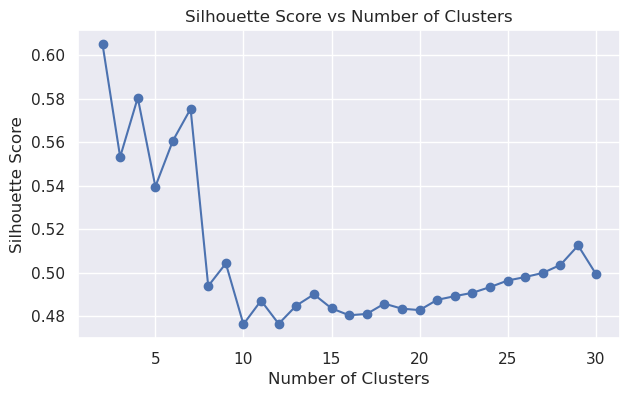

In [139]:
# Define a range of possible numbers of clusters
min_clusters = 2
max_clusters = 30

# Variables to store the silhouette scores
silhouette_scores = []

# Iterate over different numbers of clusters
for num_clusters in range(min_clusters, max_clusters+1):
    # Use fcluster to assign cluster labels
    clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

    # Calculate the silhouette score
    score = silhouette_score(distances, clusters)
    
    # Store the silhouette score
    silhouette_scores.append(score)

silhouette_scores_prefiltering = silhouette_scores.copy()

# Plot the silhouette scores against the number of clusters
plt.figure(figsize=(7,4))
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.savefig("assets/figures/Figure_2/silhouette_maxima_plot.png")
plt.show()

## Pick the best clusters

In [8]:
n_clusters = 7

## Get cluster assignments

In [9]:
# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Create dataframe assigning genomes to clusters
df_mash_clusters_kmeans = pd.DataFrame({'Cluster': clusters}, index=df_similarity.index)

# Define the colors for 15 detected clusters
color_set_15 = ["#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6", "#d2f53c", "#fabebe", "#008080", "#e6beff", "#aa6e28", "#fffac8", "#800000"]
cluster_list = sorted(df_mash_clusters_kmeans.Cluster.unique())
cluster_color_dict = dict(zip(cluster_list, color_set_15[:len(cluster_list)]))

# Update df_mash_clusters
df_mash_clusters_kmeans["Cluster_Color"] = [cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Cluster"]] for genome_id in df_mash_clusters_kmeans.index]
df_mash_clusters_kmeans["Species"] = df_gtdb_meta.loc[df_mash_clusters_kmeans.index,"Species"]
df_mash_clusters_kmeans = df_mash_clusters_kmeans.loc[df_reordered.index, :]

df_mash_clusters_kmeans.to_csv("assets/tables/df_mash_clusters_main.csv")

## Plot clustermap with all genomes

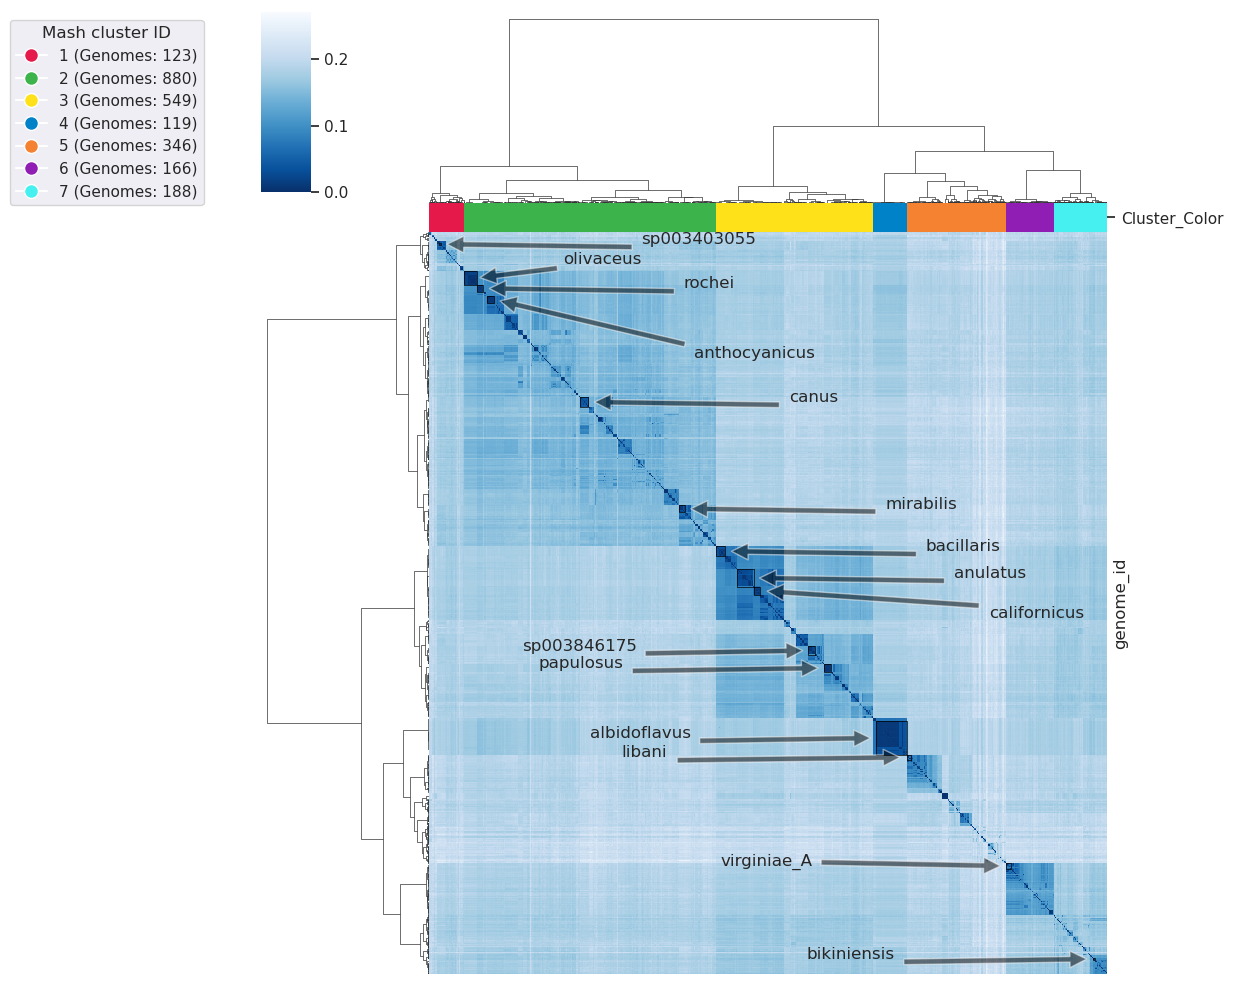

In [10]:
# Plotting the clustermap below the dendrogram
col_colors = df_mash_clusters_kmeans["Cluster_Color"]
sns.set(font_scale=1.0)  # Adjust font size for row labels
g = sns.clustermap(df_mash, cmap='Blues_r', 
                   row_linkage=linkage_matrix, col_linkage=linkage_matrix, 
                   col_colors= col_colors,
                   xticklabels=False, yticklabels=False)

# Create a color legend with unique cluster colors
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[cluster],
                           markersize=10) for cluster in sorted(cluster_list)]

cluster_sizes = df_mash_clusters_kmeans.Cluster.value_counts()
labels = [f"{cluster} (Genomes: {cluster_sizes[cluster]})" for cluster in sorted(cluster_list)]

# Add color legend
plt.legend(color_legend, labels, title='Mash cluster ID', bbox_to_anchor=(-1, 1))

# Highlight particular species
species_list = ["albidoflavus", "anulatus", "olivaceus", "bacillaris", "canus", "sp003846175", 
                "papulosus", "anthocyanicus", "californicus", "mirabilis", "rochei", "virginiae_A", 
                "libani", "sp003403055", "bikiniensis"]

for selected_species in species_list:
    x_min = 0 
    y_min = 0 
    xy_size = 0
    
    for idx in range(df_mash_clusters_kmeans.shape[0]):
        if selected_species == df_mash_clusters_kmeans.iloc[idx, 2]:
            xy_size = xy_size + 1
            if x_min == 0:
                x_min = idx
                y_min = idx      
    
    highlight = Rectangle((x_min, y_min), xy_size, xy_size, fill=False, edgecolor='black', lw=0.5)  # square with lower-left corner at (0,0), width and height 2
    g.ax_heatmap.add_patch(highlight)
    g.ax_heatmap.plot()  # Refresh the plot
    
    # Adding text label
    if selected_species == "olivaceus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+300, y_min-20),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif selected_species == "anthocyanicus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+200),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif selected_species == "californicus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+800, y_min+100),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif selected_species == "parvus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+200),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif x_min > 1200:
        g.ax_heatmap.annotate(selected_species, xy=(x_min, y_min+xy_size/2), xytext=(x_min-1000, y_min+xy_size/2),
                     arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    else:
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+xy_size/2),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))

plt.savefig("assets/figures/Figure_2/mash_clustermap_all.png", bbox_inches="tight")
plt.show()

## Silhouette coefficient assessment

Assess the above clustering using the silhouette coefficient for each of the detected clusters

In [11]:
n_clusters = 7

cluster_mapping_dict = {1:2, 2:3, 3:6, 4:7, 5:5, 6:4, 7:1}

color_map = {'1': '#e6194b',
 '2': '#3cb44b',
 '3': '#ffe119',
 '4': '#0082c8',
 '5': '#f58231',
 '6': '#911eb4',
 '7': '#46f0f0'}

# Select samples above a threshold
threshold = 0.4

In [12]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.copy()
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]


# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(distances, clusters)

df_silhouette = pd.DataFrame({"Cluster": clusters, "Silhouette": silhouette_values}, index=df_similarity.index)
df_silhouette.to_csv("assets/tables/df_silhouette_1.csv")

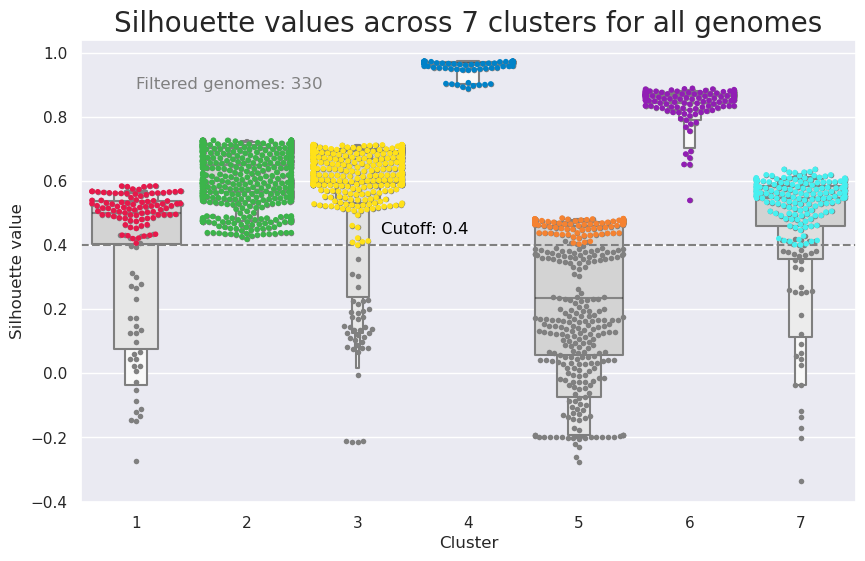

In [13]:
# Select samples above a threshold
data = df_silhouette.copy()
filtered_data = data[data["Silhouette"] >= threshold]

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
plt.axhline(y=threshold, color='gray', linestyle='--', label='Cutoff Value')
plt.text(3, threshold + 0.05, f'Cutoff: {threshold}', color='black', ha='right', va='center')
plt.text(0, 0.9, f'Filtered genomes: {data.shape[0] - filtered_data.shape[0]}', color='grey', ha='left', va='center')

plt.title('Silhouette values across 7 clusters for all genomes', fontdict={"size": 20})
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# Show the plot
plt.savefig("assets/figures/Figure_2/silhouette_1.png", bbox_inches="tight")
plt.show()

## Iterate the clustering step till 0.4 cutoff is reached for all genomes

In [14]:
cluster_mapping_dict = {1:2, 2:3, 3:6, 4:7, 5:5, 6:4, 7:1}

In [15]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[filtered_data.index, filtered_data.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(distances, clusters)

clusters_updated = [cluster_mapping_dict[cluster_id] for cluster_id in clusters]
df_silhouette_filtered_2 = pd.DataFrame({"Cluster": clusters_updated, "Silhouette": silhouette_values}, index=df_similarity.index)
df_silhouette_filtered_2.to_csv("assets/tables/df_silhouette_2.csv")

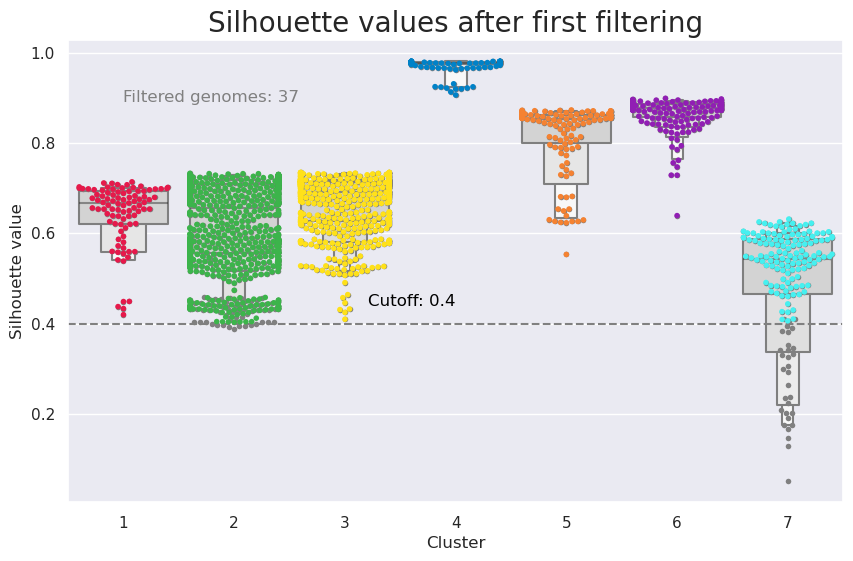

In [16]:
data = df_silhouette_filtered_2.copy()
filtered_data = data[data["Silhouette"] >= threshold]

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
plt.axhline(y=threshold, color='gray', linestyle='--', label='Cutoff Value')
plt.text(3, threshold + 0.05, f'Cutoff: {threshold}', color='black', ha='right', va='center')
plt.text(0, 0.9, f'Filtered genomes: {data.shape[0] - filtered_data.shape[0]}', color='grey', ha='left', va='center')

plt.title('Silhouette values after first filtering', fontdict={"size": 20})
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# Show the plot
plt.savefig("assets/figures/Figure_2/silhouette_2.png", bbox_inches="tight")
plt.show()

### Second round of filtering

In [17]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[filtered_data.index, filtered_data.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(distances, clusters)

clusters_updated = [cluster_mapping_dict[cluster_id] for cluster_id in clusters]
df_silhouette_filtered_3 = pd.DataFrame({"Cluster": clusters_updated, "Silhouette": silhouette_values}, index=df_similarity.index)
df_silhouette_filtered_3.to_csv("assets/tables/df_silhouette_3.csv")

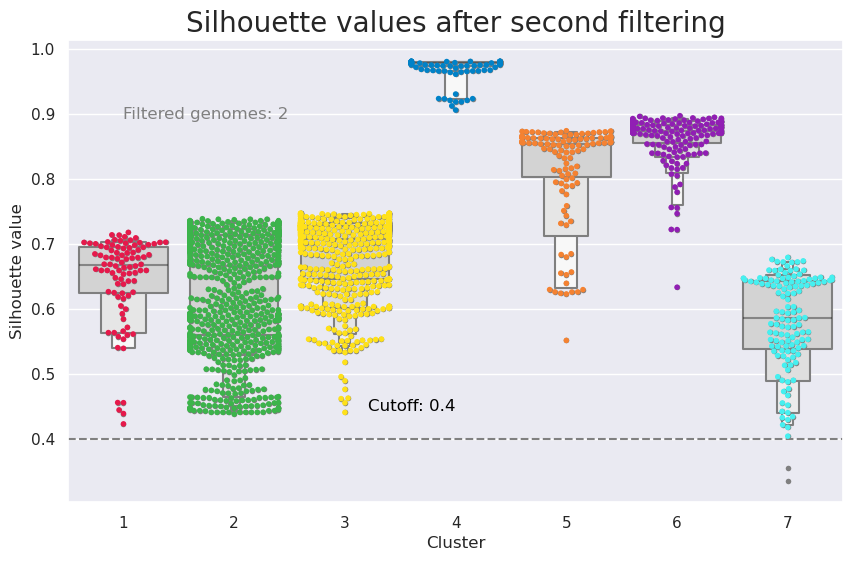

In [18]:
data = df_silhouette_filtered_3.copy()
filtered_data = data[data["Silhouette"] >= threshold]

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
plt.axhline(y=threshold, color='gray', linestyle='--', label='Cutoff Value')
plt.text(3, threshold + 0.05, f'Cutoff: {threshold}', color='black', ha='right', va='center')
plt.text(0, 0.9, f'Filtered genomes: {data.shape[0] - filtered_data.shape[0]}', color='grey', ha='left', va='center')

plt.title('Silhouette values after second filtering', fontdict={"size": 20})
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# Show the plot
plt.savefig("assets/figures/Figure_2/silhouette_3.png", bbox_inches="tight")
plt.show()

### Third round of filtering

In [19]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[filtered_data.index, filtered_data.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(distances, clusters)

clusters_updated = [cluster_mapping_dict[cluster_id] for cluster_id in clusters]
df_silhouette_filtered_4 = pd.DataFrame({"Cluster": clusters_updated, "Silhouette": silhouette_values}, index=df_similarity.index)
df_silhouette_filtered_4.to_csv("assets/tables/df_silhouette_4.csv")

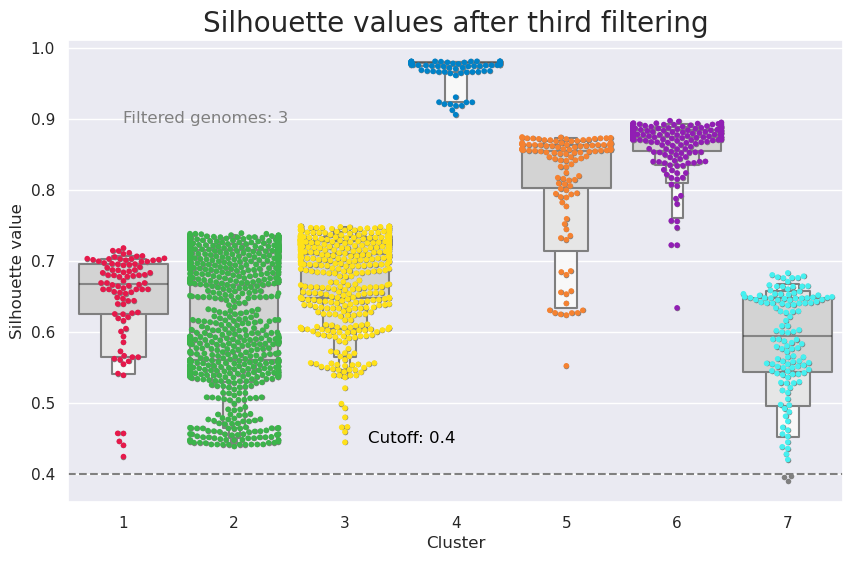

In [20]:
data = df_silhouette_filtered_4.copy()
filtered_data = data[data["Silhouette"] >= threshold]

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
plt.axhline(y=threshold, color='gray', linestyle='--', label='Cutoff Value')
plt.text(3, threshold + 0.05, f'Cutoff: {threshold}', color='black', ha='right', va='center')
plt.text(0, 0.9, f'Filtered genomes: {data.shape[0] - filtered_data.shape[0]}', color='grey', ha='left', va='center')

plt.title('Silhouette values after third filtering', fontdict={"size": 20})
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# Show the plot
plt.savefig("assets/figures/Figure_2/silhouette_4.png", bbox_inches="tight")
plt.show()

### Fourth round of filtering

In [21]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[filtered_data.index, filtered_data.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(distances, clusters)

clusters_updated = [cluster_mapping_dict[cluster_id] for cluster_id in clusters]
df_silhouette_filtered_5 = pd.DataFrame({"Cluster": clusters_updated, "Silhouette": silhouette_values}, index=df_similarity.index)
df_silhouette_filtered_5.to_csv("assets/tables/df_silhouette_5.csv")

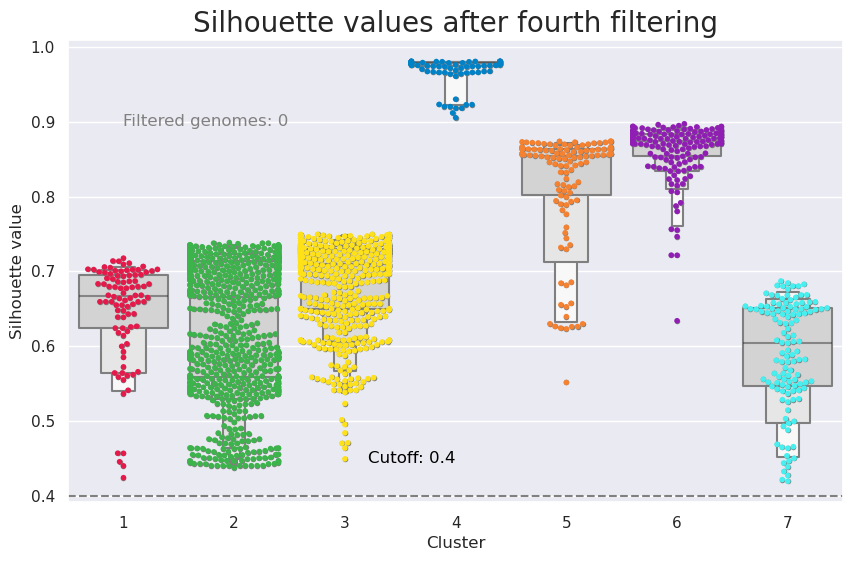

In [22]:
data = df_silhouette_filtered_5.copy()
filtered_data = data[data["Silhouette"] >= threshold]

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
plt.axhline(y=threshold, color='gray', linestyle='--', label='Cutoff Value')
plt.text(3, threshold + 0.05, f'Cutoff: {threshold}', color='black', ha='right', va='center')
plt.text(0, 0.9, f'Filtered genomes: {data.shape[0] - filtered_data.shape[0]}', color='grey', ha='left', va='center')

plt.title('Silhouette values after fourth filtering', fontdict={"size": 20})
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# Show the plot
plt.savefig("assets/figures/Figure_2/silhouette_5.png", bbox_inches="tight")
plt.show()

### Plot Silhouette averages before and after removing noise

In [140]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[df_silhouette_filtered_5.index, df_silhouette_filtered_5.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

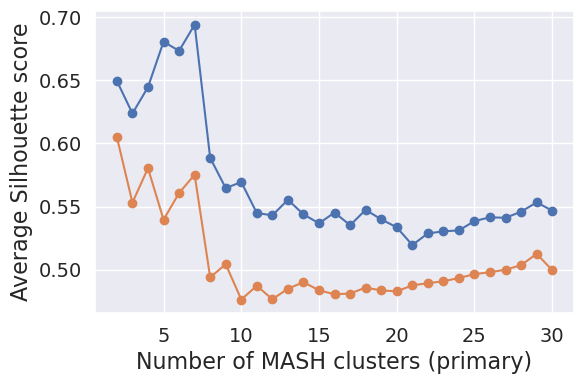

In [142]:
# Define a range of possible numbers of clusters
min_clusters = 2
max_clusters = 30

# Variables to store the silhouette scores
silhouette_scores = []

# Iterate over different numbers of clusters
for num_clusters in range(min_clusters, max_clusters+1):
    # Use fcluster to assign cluster labels
    clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

    # Calculate the silhouette score
    score = silhouette_score(distances, clusters)
    
    # Store the silhouette score
    silhouette_scores.append(score)
    
# Plot the silhouette scores against the number of clusters
plt.figure(figsize=(6,4))
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores_prefiltering, marker='o')
plt.xlabel('Number of MASH clusters (primary)', fontsize=16)
plt.ylabel('Average Silhouette score', fontsize=16)

# Set tick label size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

plt.savefig("assets/figures/Figure_2/silhouette_maxima_comparison.png")
plt.savefig("assets/figures/Figure_2/silhouette_maxima_comparison.svg")

plt.show()

In [136]:
color_map

{'1': '#e6194b',
 '2': '#3cb44b',
 '3': '#ffe119',
 '4': '#0082c8',
 '5': '#f58231',
 '6': '#911eb4',
 '7': '#46f0f0'}

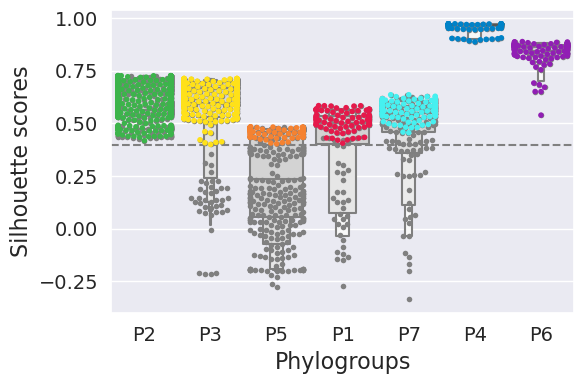

In [41]:
# Select samples above a threshold
data = df_silhouette.copy()
filtered_data = df_silhouette.loc[df_silhouette_filtered_5.index, :]

data['Cluster'] = data['Cluster'].apply(lambda x: f'P{x}')
filtered_data['Cluster'] = filtered_data['Cluster'].apply(lambda x: f'P{x}')
color_map_phylogroups = {f'P{key}': value for key, value in color_map.items()}
# Create the boxenplot using the filtered data
plt.figure(figsize=(6, 4))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map_phylogroups)
plt.axhline(y=threshold, color='gray', linestyle='--')

plt.xlabel('Phylogroups', fontsize=16)
plt.ylabel('Silhouette scores', fontsize=16)

# Set tick label size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

# Show the plot
plt.savefig("assets/figures/Figure_2/silhouette_filter_comparison.png")
plt.savefig("assets/figures/Figure_2/silhouette_filter_comparison.svg")

plt.show()

## Varible cutoff strategy - Ignored

In [29]:
# data = df_silhouette.copy()
# # Define the quantiles to restrict the plot for each category
# lower_cutoffs = {1:0.35, 2:0.4, 3:0.48, 4:0.85, 5:0.30, 6:0.7, 7:0.3}

# # Create an empty list to store the filtered data for each category
# filtered_data_list = []

# color_map = {'1': '#e6194b',
#  '2': '#3cb44b',
#  '3': '#ffe119',
#  '4': '#0082c8',
#  '5': '#f58231',
#  '6': '#911eb4',
#  '7': '#46f0f0'}

# # Iterate through each category and filter the data based on the quantiles
# for category in sorted(data['Cluster'].unique()):
#     category_data = data[data['Cluster'] == category]
#     cutoff_value = lower_cutoffs[category]
#     filtered_category_data = category_data[category_data['Silhouette'] >= cutoff_value]
#     filtered_data_list.append(filtered_category_data)
    
# # Concatenate the filtered data for all categories
# filtered_data = pd.concat(filtered_data_list)

# # Create the boxenplot using the filtered data
# plt.figure(figsize=(10, 6))
# sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
# sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
# sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
# sns.pointplot(x='Cluster', y='Silhouette', data=data, color='black', markers='x', join=False, ci=None)
# sns.pointplot(x='Cluster', y='Silhouette', data=pd.DataFrame(list(lower_cutoffs.items()), columns=['Cluster', 'Silhouette']),
#               color='red', markers='s', join=False, ci=None)
# plt.title('Silhouette values across detected clusters for all genomes')
# plt.xlabel('Cluster')
# plt.ylabel('Silhouette value')

# # # Plot the chosen lower cutoff values
# for category, value in lower_cutoffs.items():
#     category_data = data[data['Cluster'] == category]
#     plt.text(category - 1.4, category_data.Silhouette.max() + 0.02, f'Cutoff: {value:.2f}', color='black')

# filtered_data.to_csv("assets/tables/df_silhouette_varaible.csv")

# # Show the plot
# plt.savefig("assets/figures/Figure_2/silhouette_all_variable_cutoff.png")
# plt.show()

# 2. Reduced dataset by filtering wrongly clustered samples

In [82]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.copy()
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

In [83]:
n_clusters = 7

## Get cluster assignments

In [84]:
# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Create dataframe assigning genomes to clusters
df_mash_clusters_kmeans = pd.DataFrame({'Cluster': clusters}, index=df_similarity.index)

# Update df_mash_clusters
df_mash_clusters_kmeans["Cluster_Color"] = [cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Cluster"]] for genome_id in df_mash_clusters_kmeans.index]
df_mash_clusters_kmeans["Species"] = df_gtdb_meta.loc[df_mash_clusters_kmeans.index,"Species"]
df_mash_clusters_kmeans = df_mash_clusters_kmeans.loc[df_reordered.index, :]

## Plot clustermap with all genomes

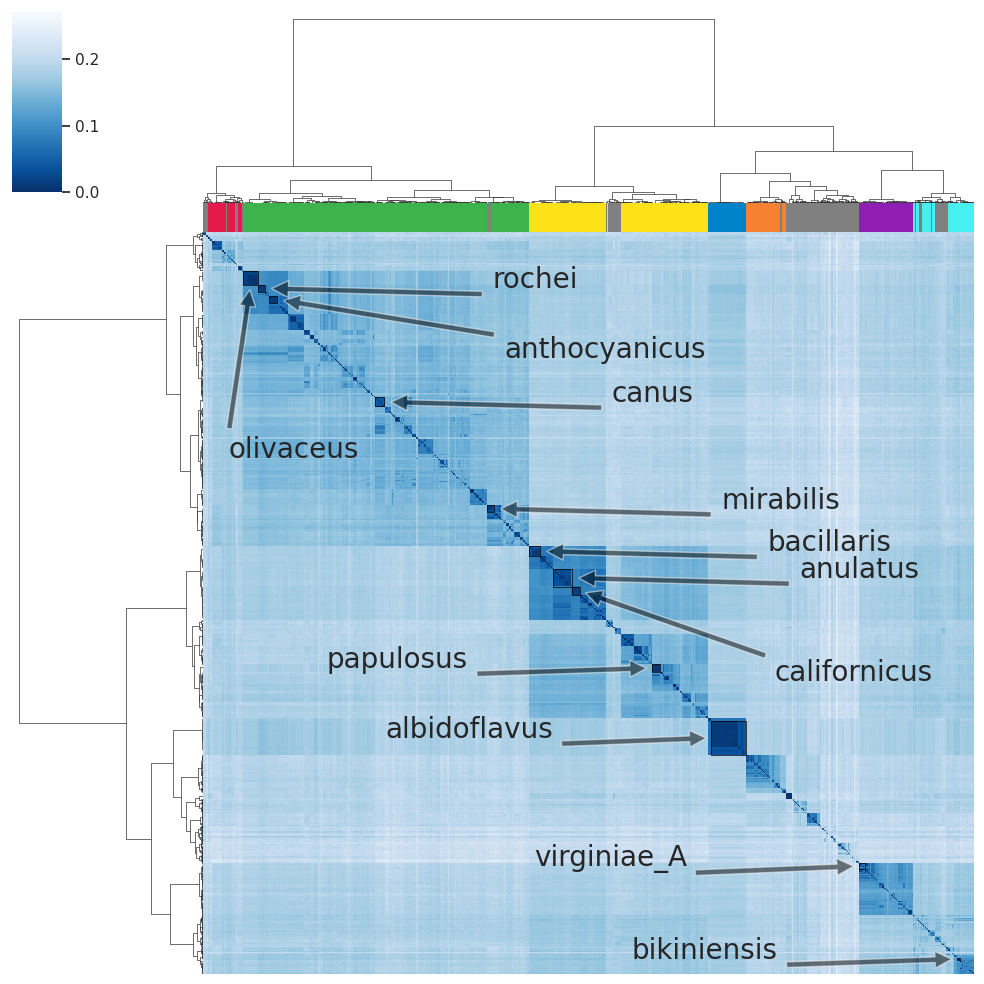

In [86]:
df_mash.index.name = ""
df_mash.columns.name = ""

# Plotting the clustermap below the dendrogram
col_colors = [df_mash_clusters_kmeans.loc[genome_id, "Cluster_Color"] if genome_id in filtered_data.index.tolist() else "#808080" for genome_id in df_mash.index]

sns.set(font_scale=1.0)  # Adjust font size for row labels
g = sns.clustermap(df_mash, cmap='Blues_r', 
                   row_linkage=linkage_matrix, col_linkage=linkage_matrix, 
                   col_colors= col_colors,
                   xticklabels=False, yticklabels=False)

# Create a color legend with unique cluster colors
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[cluster],
                           markersize=10) for cluster in sorted(cluster_list)]

cluster_sizes = df_mash_clusters_kmeans.Cluster.value_counts()
labels = [f"{cluster} (Genomes: {cluster_sizes[cluster]})" for cluster in sorted(cluster_list)]

# # Add color legend
# plt.legend(color_legend, labels, title='Mash cluster ID', bbox_to_anchor=(-1, 1))

# Highlighting square
from matplotlib.patches import Rectangle

species_list = ["albidoflavus", "anulatus", "olivaceus", "bacillaris", "canus",
                "papulosus", "anthocyanicus", "californicus", "mirabilis", "rochei", "virginiae_A", 
                "bikiniensis"]

for selected_species in species_list:
    x_min = 0 
    y_min = 0 
    xy_size = 0
    
    for idx in range(df_mash_clusters_kmeans.shape[0]):
        if selected_species == df_mash_clusters_kmeans.iloc[idx, 2]:
            xy_size = xy_size + 1
            if x_min == 0:
                x_min = idx
                y_min = idx      
    
    highlight = Rectangle((x_min, y_min), xy_size, xy_size, fill=False, edgecolor='black', lw=0.5)  # square with lower-left corner at (0,0), width and height 2
    g.ax_heatmap.add_patch(highlight)
    g.ax_heatmap.plot()  # Refresh the plot
    
    # Adding text label
    if selected_species == "olivaceus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size/2, y_min+xy_size), xytext=(x_min-xy_size, y_min+600),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=20)
    elif selected_species == "anthocyanicus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+200),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=20)
    elif selected_species == "californicus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+600, y_min+300),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=20)
    elif selected_species == "parvus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+200),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=20)
    elif x_min > 1200:
        g.ax_heatmap.annotate(selected_species, xy=(x_min, y_min+xy_size/2), xytext=(x_min-1000, y_min+xy_size/2),
                     arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=20)
    else:
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+xy_size/2),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=20)

plt.savefig("assets/figures/Figure_2/mash_clustermap_filtered_all.png")
plt.show()

# Recluster the reduced Mash matrix

## Perform heirarchical clustering

1. Convert distance matrix to similarity
2. Compute pairwise distances using Pearson's correlation coefficient to be used as feature tables
3. Performing hierarchical clustering using ward.D2 method to get linkage matrix

In [77]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[df_silhouette_filtered_5.index, df_silhouette_filtered_5.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

In [78]:
n_clusters = 7

## Get cluster assignments

In [79]:
# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

cluster_mapping_dict = {1:2, 2:3, 3:6, 4:7, 5:5, 6:4, 7:1}
# Create dataframe assigning genomes to clusters
df_mash_clusters_kmeans = pd.DataFrame({'Cluster': [cluster_mapping_dict[cluster_id] for cluster_id in clusters]}, index=df_similarity.index)

# Update df_mash_clusters
df_mash_clusters_kmeans["Cluster_Color"] = [cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Cluster"]] for genome_id in df_mash_clusters_kmeans.index]
df_mash_clusters_kmeans["Species"] = df_gtdb_meta.loc[df_mash_clusters_kmeans.index,"Species"]
df_mash_clusters_kmeans = df_mash_clusters_kmeans.loc[df_reordered.index, :]

df_mash_clusters_kmeans.to_csv("assets/tables/df_mash_clusters_main_reduced.csv")

## Plot clustermap with all genomes

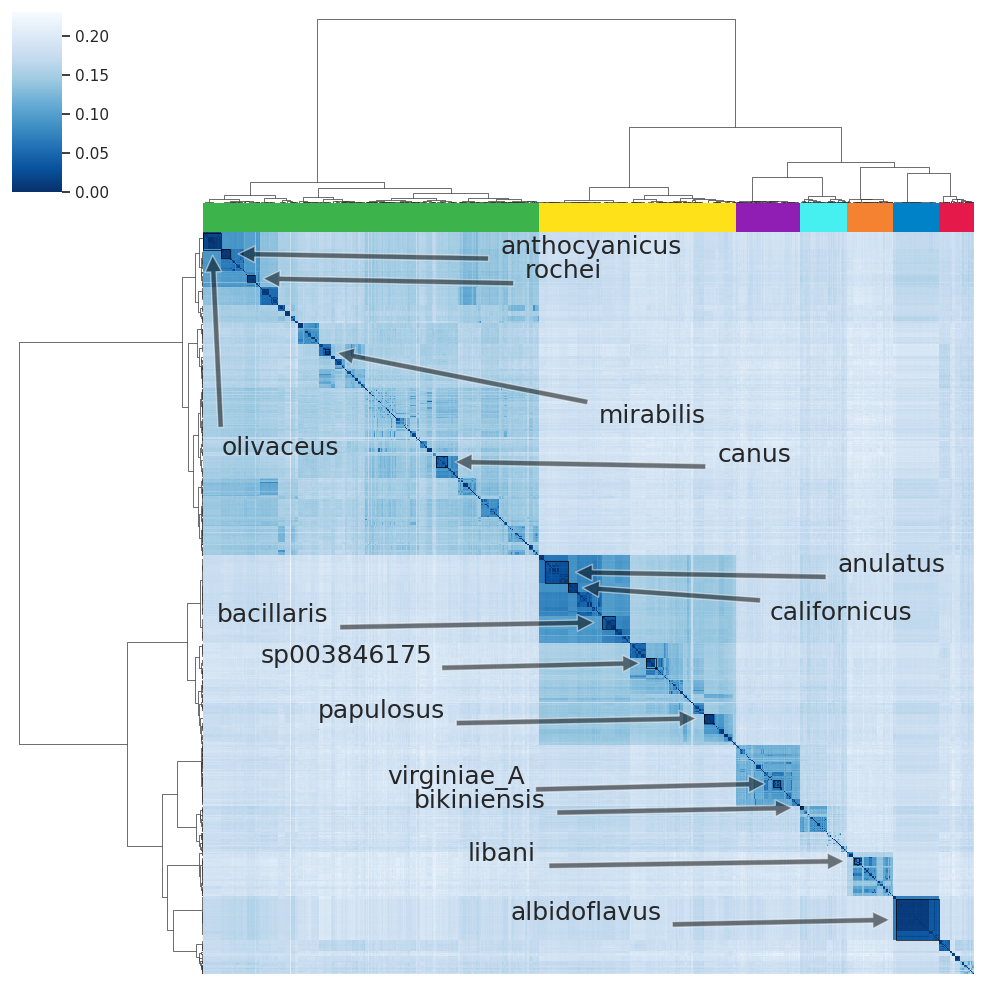

In [80]:
# Plotting the clustermap below the dendrogram
df_mash.index.name = ""
df_mash.columns.name = ""

# Plotting the clustermap below the dendrogram
col_colors = [df_mash_clusters_kmeans.loc[genome_id, "Cluster_Color"] if genome_id in filtered_data.index.tolist() else "#808080" for genome_id in df_mash.index]
# col_colors =df_mash_clusters_kmeans.loc[df_mash.index, "Cluster_Color"]

sns.set(font_scale=1.0)  # Adjust font size for row labels
g = sns.clustermap(df_mash, cmap='Blues_r', 
                   row_linkage=linkage_matrix, col_linkage=linkage_matrix, 
                   col_colors= col_colors,
                   xticklabels=False, yticklabels=False)

# Create a color legend with unique cluster colors
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[cluster],
                           markersize=10) for cluster in sorted(cluster_list)]

cluster_sizes = df_mash_clusters_kmeans.Cluster.value_counts()
labels = [f"{cluster} (Genomes: {cluster_sizes[cluster]})" for cluster in sorted(cluster_list)]

# # Add color legend
# plt.legend(color_legend, labels, title='Mash cluster ID', bbox_to_anchor=(-1, 1))

# Highlighting square
species_list = ["albidoflavus", "anulatus", "olivaceus", "bacillaris", "canus", "sp003846175", 
                "papulosus", "anthocyanicus", "californicus", "mirabilis", "rochei", "virginiae_A", 
                "libani", "bikiniensis"]
for selected_species in species_list:
    x_min = 0 
    y_min = 0 
    xy_size = 0
    
    for idx in range(df_mash_clusters_kmeans.shape[0]):
        if selected_species == df_mash_clusters_kmeans.iloc[idx, 2]:
            xy_size = xy_size + 1
            if x_min == 0:
                x_min = idx
                y_min = idx      
    
    highlight = Rectangle((x_min, y_min), xy_size, xy_size, fill=False, edgecolor='black', lw=0.5)  # square with lower-left corner at (0,0), width and height 2
    g.ax_heatmap.add_patch(highlight)
    g.ax_heatmap.plot()  # Refresh the plot
    
    # Adding text label
    if selected_species == "olivaceus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size/2, y_min+xy_size), xytext=(x_min+xy_size, y_min+600),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=18)
    elif selected_species == "mirabilis":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+200),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=18)
    elif selected_species == "californicus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+500, y_min+100),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=18)
    elif selected_species == "parvus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+200),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=18)
    elif x_min > 1000:
        g.ax_heatmap.annotate(selected_species, xy=(x_min, y_min+xy_size/2), xytext=(x_min-1000, y_min+xy_size/2),
                     arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=18)
    else:
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+xy_size/2),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5), fontsize=18)

plt.savefig("assets/figures/Figure_2/mash_clustermap_reduced.png")
plt.show()

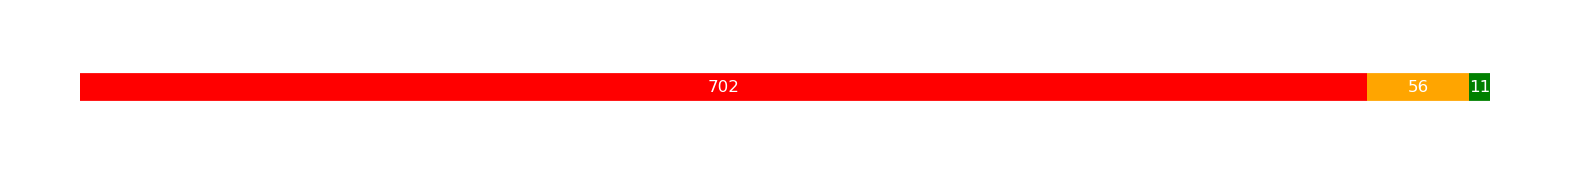

In [98]:
GTDB(741/574/930)
GETPHYLO(741/1021/532)
AMLST(741/232/1395)

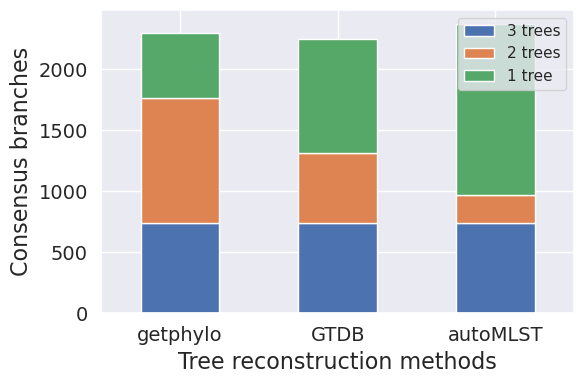

In [128]:
data = {
    'getphylo': [741, 1021, 532],
    'GTDB': [741, 574, 930],
    'autoMLST': [741, 232, 1395]
}
df_trees = pd.DataFrame(data)
df_trees.index = ["3 trees", "2 trees", "1 tree"]
df_trees = df_trees.T

# Creating a stacked bar plot
ax = df_trees.plot(kind='bar', stacked=True, figsize=(6, 4))

# Adding titles and labels
ax.set_xlabel('Tree reconstruction methods', fontsize=16)
ax.set_ylabel('Consensus branches', fontsize=16)

# Customizing tick sizes
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()

plt.savefig("assets/figures/Figure_2/tree_consensus.svg")
plt.savefig("assets/figures/Figure_2/tree_consensus.png")

# Displaying the plot
plt.show()

In [135]:
df_tmp = pd.read_csv("/datadrive/bgcflow/data/processed/mq_strepto/tables/df_filters.csv", index_col=0)
df_tmp[(df_tmp.source == "NBC") & (df_tmp.quality == "HQ")].sort_values(by="genome_len")[:10]

genome_id.1         genus source            species quality  \
genome_id                                                               
NBC_01629   NBC_01629  Streptomyces    NBC  thermodiastaticus      HQ   
NBC_00566   NBC_00566  Streptomyces    NBC        sp019090105      HQ   
NBC_01171   NBC_01171  Streptomyces    NBC                sp.      HQ   
NBC_01103   NBC_01103  Streptomyces    NBC        diastaticus      HQ   
NBC_00388   NBC_00388  Streptomyces    NBC                sp.      HQ   
NBC_00726   NBC_00726  Streptomyces    NBC        sp001905735      HQ   
NBC_01215   NBC_01215  Streptomyces    NBC       xinghaiensis      HQ   
NBC_01178   NBC_01178  Streptomyces    NBC        sp001905905      HQ   
NBC_01271   NBC_01271  Streptomyces    NBC       albidoflavus      HQ   
NBC_01601   NBC_01601  Streptomyces    NBC        sp019090105      HQ   

           completeness  contamination      N50  contigs  genome_len        gc  
genome_id                                                                       
NBC_01629     99.570815       0.321888  6066002        1     6066002  0.724763  
NBC_00566    100.000000       1.072961  6411420        1     6411420  0.717972  
NBC_01171    100.000000       0.643777  6584968        1     6584968  0.716095  
NBC_01103     99.892704       0.214592  6721603        1     6721603  0.735180  
NBC_00388     99.792408       0.948992  6771125        2     6859429  0.708794  
NBC_00726    100.000000       1.423488  6652437        2     6875124  0.718143  
NBC_01215    100.000000       0.000000  6900143        1     6900143  0.732133  
NBC_01178    100.000000       0.241484  6801306        3     6968086  0.727461  
NBC_01271     99.892704       0.786838  6978313        1     6978313  0.734010  
NBC_01601    100.000000       1.287554  6514704        3     6984865  0.716792